In [1]:
!pip install fastai

In [2]:
from fastai.vision.all import *

/home/dnth/anaconda3/envs/fastdup/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = Path('./scene_classification_clean/data/')

In [4]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(150)],
        batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75))

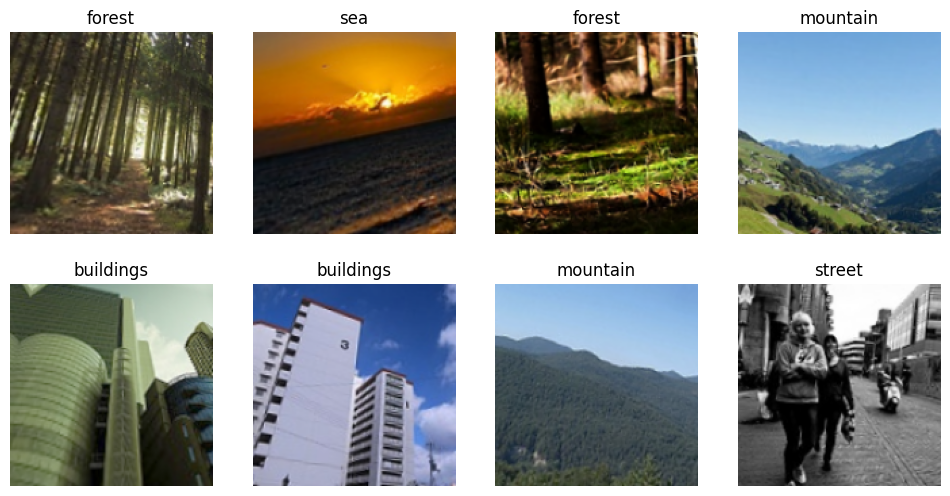

In [5]:

loaders = block.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2)

In [6]:
learn = vision_learner(loaders, resnet18, metrics=accuracy)

/home/dnth/anaconda3/envs/fastdup/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dnth/anaconda3/envs/fastdup/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0006918309954926372)

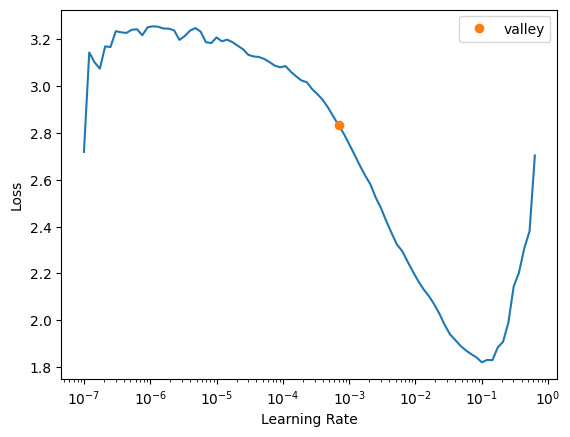

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.697845,0.439790,0.850467,00:09


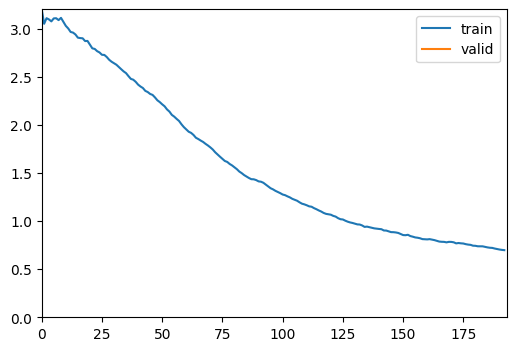

epoch,train_loss,valid_loss,accuracy,time
0,0.462241,0.360062,0.885272,00:11
1,0.399387,0.285320,0.906220,00:10
2,0.310712,0.285150,0.908153,00:11
3,0.266194,0.238014,0.923945,00:12
4,0.238988,0.247504,0.921366,00:11
5,0.197433,0.274916,0.917177,00:11
6,0.187825,0.247064,0.924911,00:11
7,0.163494,0.249472,0.922011,00:12
8,0.145147,0.226579,0.934902,00:12
9,0.116050,0.242369,0.932001,00:11


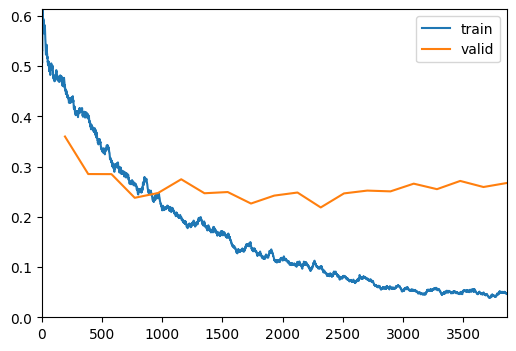

In [8]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

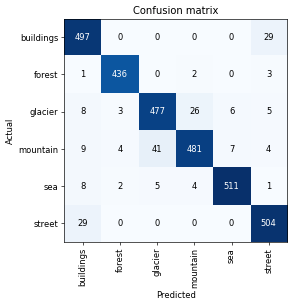

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

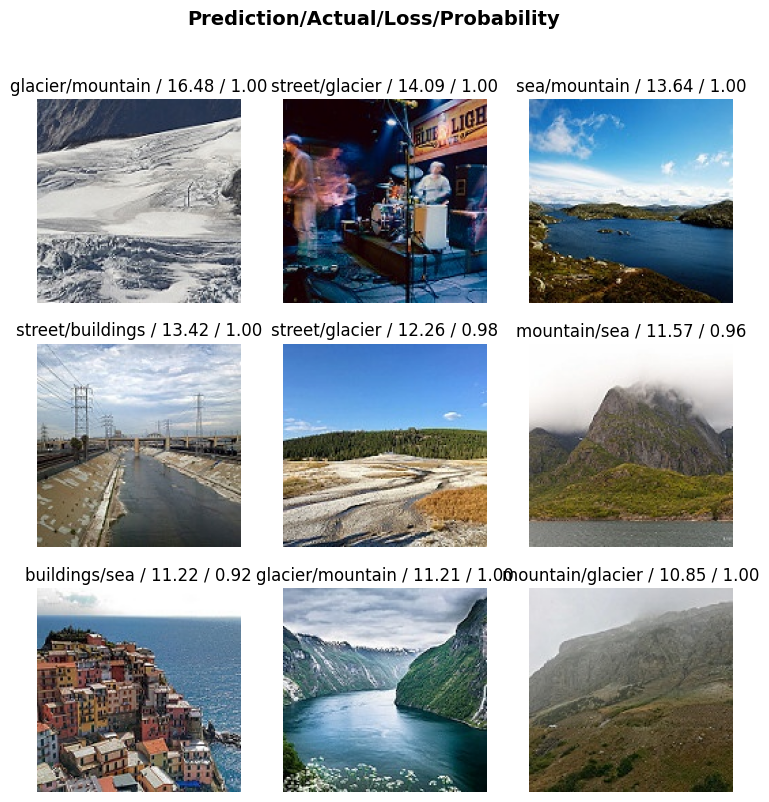

In [10]:
interp.plot_top_losses(9)